## Purpose
Predicting customer car category preference using **Random Forest Classification** based on both demographic features of customers (income, gender, region) and technical features of previous purchases (price, brand, engine, transmission)

In [8]:
# Load libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


## Load Dataset

In [9]:
# Load the cleaned dataset
excel_path = "../data/processed/Car_Sales_Clean.csv"
try:
    # Attempt to load it as an Excel file first
    df = pd.read_excel(excel_path)
except:
    # If it fails, try loading as a CSV (in case of incorrect extension)
    df = pd.read_csv(excel_path)

df.head()

,car_id,purchase_date,customer_name,gender,annual_income,dealer_name,company,model,engine,transmission,color,price,dealer_no,body_style,phone,dealer_region
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,Double Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,Double Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,1/2/2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,1/2/2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,Double Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


## Select relevant features and drop missing values

In [10]:
features = ['gender', 'annual_income', 'price', 'body_style', 'company', 'model', 'engine', 'transmission', 'color', 'dealer_region']
df_model = df[features].dropna()

## Encode categorical variables

In [11]:
le_gender = LabelEncoder()
le_body_style = LabelEncoder()
le_region = LabelEncoder()
le_company = LabelEncoder()
le_engine = LabelEncoder()
le_transmission = LabelEncoder()

df_model['gender_encoded'] = le_gender.fit_transform(df_model['gender'])
df_model['body_style_encoded'] = le_body_style.fit_transform(df_model['body_style'])
df_model['region_encoded'] = le_region.fit_transform(df_model['dealer_region'])
df_model['company_encoded'] = le_company.fit_transform(df_model['company'])
df_model['engine_encoded'] = le_engine.fit_transform(df_model['engine'])
df_model['transmission_encoded'] = le_transmission.fit_transform(df_model['transmission'])

## Define features (X) and target (y)

In [12]:
X = df_model[['gender_encoded', 'annual_income', 'price', 
              'region_encoded', 'company_encoded', 
              'engine_encoded', 'transmission_encoded']]
y = df_model['body_style_encoded']

## Train-Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model

In [14]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate the model

Classification Report:

              precision    recall  f1-score   support

     Hardtop       0.50      0.48      0.49       572
   Hatchback       0.69      0.71      0.70      1200
   Passenger       0.84      0.81      0.82       804
         SUV       0.71      0.71      0.71      1304
       Sedan       0.76      0.76      0.76       902

    accuracy                           0.71      4782
   macro avg       0.70      0.69      0.70      4782
weighted avg       0.71      0.71      0.71      4782

Model Accuracy: 0.71


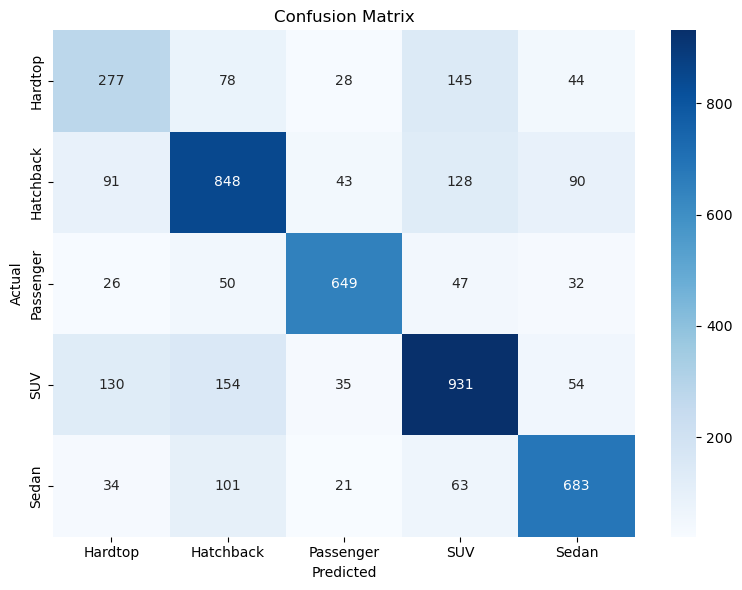

In [15]:
# Predict on test data
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le_body_style.classes_))
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_body_style.classes_,
            yticklabels=le_body_style.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [16]:
car_categories = le_body_style.classes_

# getting data for actual trend
actual_values = conf_matrix.sum(axis=1)

# getting data for the predicted trend
predicted_values = conf_matrix.sum(axis=0)

car_sales_actual = pd.DataFrame({'Car Category': car_categories, 'Value': actual_values, 'Source': 'Actual'})
car_sales_actual = car_sales_actual.sort_values('Value', ascending=False)
car_sales_actual

,Car Category,Value,Source
3,SUV,1304,Actual
1,Hatchback,1200,Actual
4,Sedan,902,Actual
2,Passenger,804,Actual
0,Hardtop,572,Actual


In [18]:
car_sales_predicted = pd.DataFrame({'Car Category': car_categories, 'Value': predicted_values, 'Source': 'Predicted'})
car_sales_predicted = car_sales_predicted.sort_values('Value', ascending=False)
car_sales_predicted

,Car Category,Value,Source
3,SUV,1314,Predicted
1,Hatchback,1231,Predicted
4,Sedan,903,Predicted
2,Passenger,776,Predicted
0,Hardtop,558,Predicted


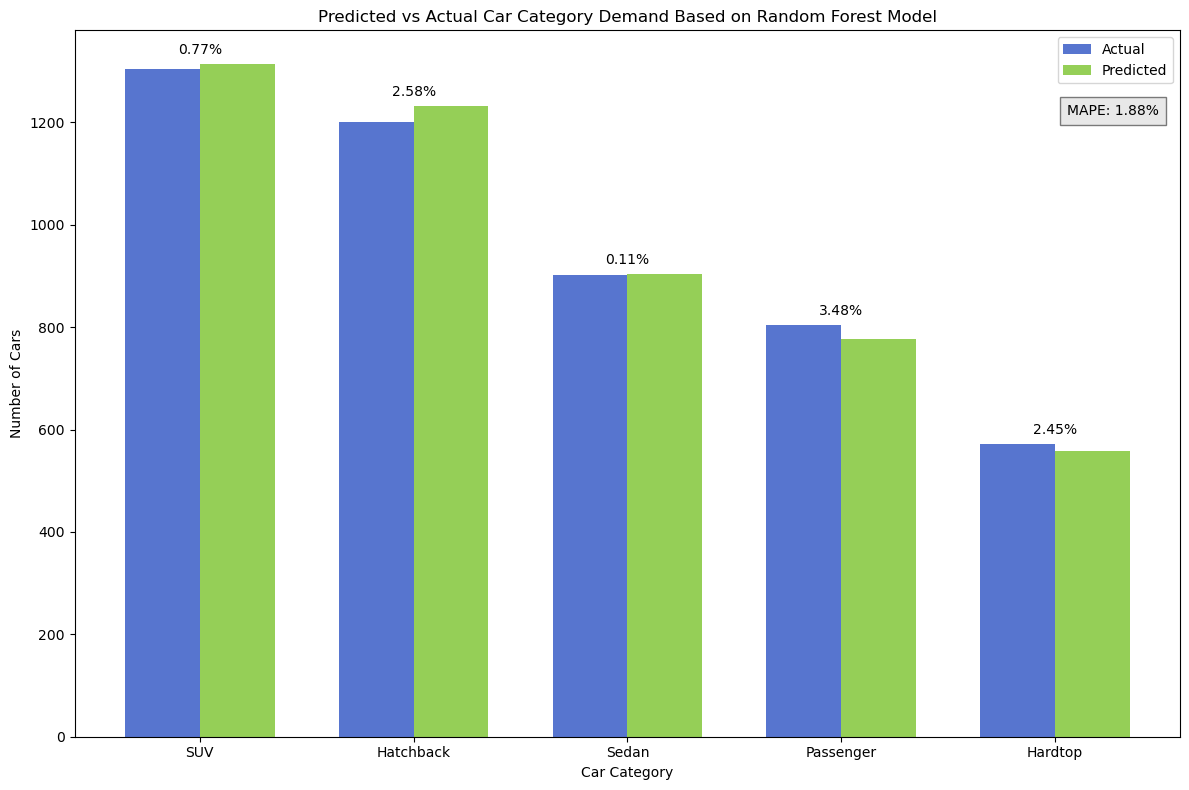

In [20]:
# calculating and visualizing Mean Absolute Percentage Error (MAPE) for the prediction:
import numpy as np
category = car_sales_predicted['Car Category'].values
predicted = car_sales_predicted['Value'].values
actual = car_sales_actual['Value'].values
percent_error = [abs(p - a) / a * 100 for p, a in zip(predicted, actual)]
mape = np.mean(percent_error)

mape_summary = pd.DataFrame({
    'Car Category': car_categories,
    'Predicted': predicted,
    'Actual': actual,
    '% Error': percent_error
})

fig, ax1 = plt.subplots(figsize=(12, 8))
x = np.arange(len(category))
width = 0.35
ax1.bar(x - width/2, mape_summary['Actual'], width, label='Actual', color='#5775CF')
ax1.bar(x + width/2, mape_summary['Predicted'], width, label='Predicted', color='#95CF57')
ax1.set_ylabel('Number of Cars')
ax1.set_xlabel('Car Category')
ax1.set_title('Predicted vs Actual Car Category Demand Based on Random Forest Model')
ax1.set_xticks(x)
ax1.set_xticklabels(category)
ax1.legend(loc='upper right')
for i in range(len(category)):
    max_val = max(actual[i], predicted[i])
    ax1.text(x[i], max_val + 20, f"{percent_error[i]:.2f}%", ha='center', fontsize=10, color='black')

plt.figtext(0.97, 0.85, f"MAPE: {mape:.2f}%", horizontalalignment='right', fontsize=10,
            bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout()
plt.show()

In [21]:
# visualizing the total trend 
import plotly.express as px
car_sales_combo = pd.concat([car_sales_actual, car_sales_predicted], ignore_index=True)
fig = px.bar(
    car_sales_combo,
    x='Car Category',
    y='Value',
    color='Source',
    barmode='group',
    color_discrete_map={'Actual': '#5775CF', 'Predicted': '#95CF57'},
    text='Value'
)
fig.update_layout(
    width=900,
    height=500,
    title=dict(
        text='Car Category Popularity: Actual Purchases vs Predicted Purchases Based on Random Forest Model',
        x=0.5,
        xanchor='center',
        font=dict(size=17, family='Arial')
    ),
    xaxis_title='Car Category',
    yaxis_title='Value',
    bargap=0.2,
    plot_bgcolor='white',
    font=dict(size=14),
    legend=dict(
        title='Legend',
        orientation='v',
        x=1.05,
        y=1
    ),
    #xaxis=dict(
        #showgrid=True,
        #gridcolor='lightgray',
        #gridwidth=1
    #),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1
    )
)

fig.update_traces(
    textposition='outside',
    textfont_size=12
)
fig.show()

In [22]:
corr_cols = [
    'gender_encoded',
    'body_style_encoded',
    'region_encoded',
    'company_encoded',
    'engine_encoded',
    'transmission_encoded',
    'price', 
    'annual_income' 
]

df_corr = df_model[corr_cols]
correlation_matrix = df_corr.corr()
correlation_matrix

,gender_encoded,body_style_encoded,region_encoded,company_encoded,engine_encoded,transmission_encoded,price,annual_income
gender_encoded,1.000000,0.005230,0.002167,0.003499,0.002647,0.002647,-0.006592,0.054204
body_style_encoded,0.005230,1.000000,0.045144,-0.008463,-0.018050,-0.018050,0.014552,-0.005727
region_encoded,0.002167,0.045144,1.000000,-0.000762,-0.000249,-0.000249,-0.009400,-0.006084
company_encoded,0.003499,-0.008463,-0.000762,1.000000,-0.028849,-0.028849,0.021880,0.010099
engine_encoded,0.002647,-0.018050,-0.000249,-0.028849,1.000000,1.000000,-0.011271,-0.006598
transmission_encoded,0.002647,-0.018050,-0.000249,-0.028849,1.000000,1.000000,-0.011271,-0.006598
price,-0.006592,0.014552,-0.009400,0.021880,-0.011271,-0.011271,1.000000,0.012065
annual_income,0.054204,-0.005727,-0.006084,0.010099,-0.006598,-0.006598,0.012065,1.000000


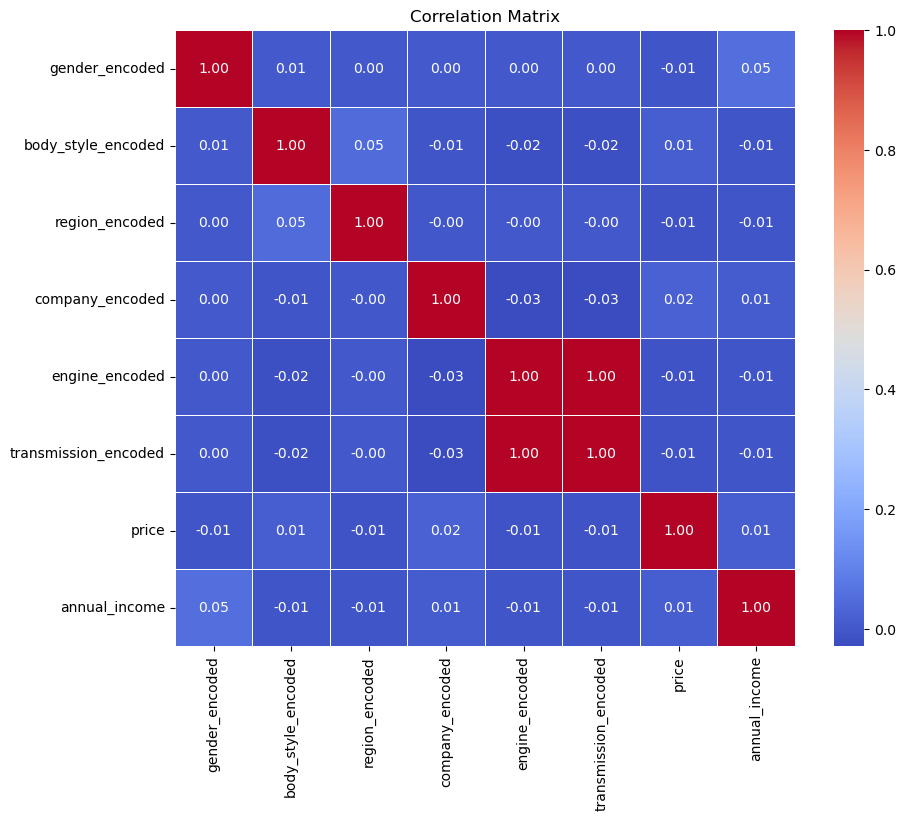

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Model Performance Summary

### Best Predicted Category: Passenger
Precision: 0.80

Recall: 0.83

F1 Score: 0.82
        Meaning: The model correctly identified 80% of actual Passenger buyers and did so with reasonable precision. This category had the highest performance.

### Weakest Predicted Category: Hardtop
Precision: 0.49 (not very precise)

Recall: 0.49 (low)

F1 Score: 0.49
     Meaning: Even when the model predicts "Hardtop," the actual purchase is of another categories - it rarely identifies correctly the true "Hardtop" buyers. 

### Other Classes:
Sedan, SUV, and Hatchback had moderate performance and close results to one another (F1 around 0.70–0.75)

### Overall Performance:
Accuracy: 71%

Macro F1 Score: 0.69

Weighted F1 Score: 0.71

Conclusion: The model performs better than random guessing, and could be considered for deployment if there is no existing model with the same purpose and better peformance. 

## Insights and recommendations for business stakeholders

### For the categories where the model is strongest (Passenger/SUV/Sedan):

- **Sales team** can focus more inventory and engage more confidently with offering of upsell options.
- **Marketing team** can leverage strong prediction for email marketing and segmentation to achieve higher conversion rate with focused messaging. 
- **Product managers** can develop bundled features, add-ons and focused product lines. 
- **Business Executives** can optimize forecasting demand to better support dealer stocking and refine regional strategy.

### For the categories where the model is weaker (Hardtop/ Hatchback):

- All stakeholders should consider manual review or additional signals (behavioral or location-based signals) before making decisions.

### Overall, while the model is promising (71% overall accuracy, strong for Passenger category), its performance varies across classes, making it valuable as a decision-support tool but not yet a fully autonomous system. Continuous improvement is needed in expanding dataset and cross-department data collaboration to enrich model inputs and model maturity.